# Study of [EPIC228735255](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=228735255)

### Clearing the events in the lightcurve:

I'll start by downloading and plotting the tpf and lc for the concerned object:

/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:141: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


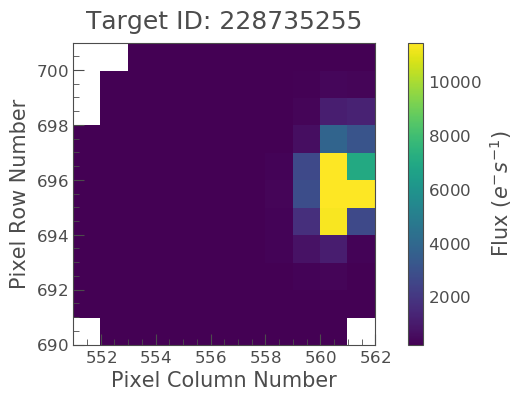

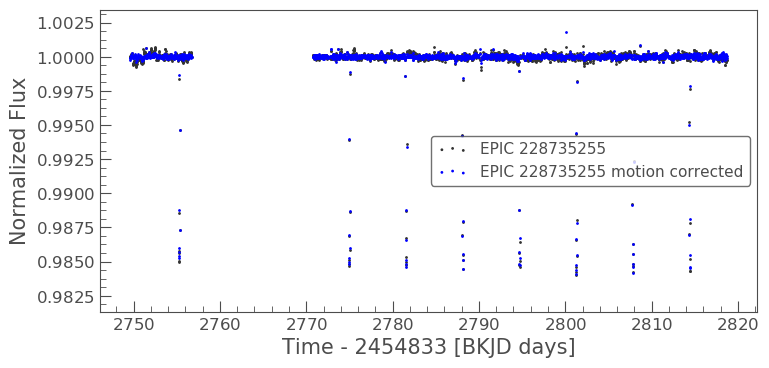

In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '228735255'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.flatten(window_length=301).remove_nans().remove_outliers(sigma_lower=100,sigma_upper=0.4)
ax = lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=301, return_trend=True)
corr_lc_f.scatter(ax=ax,color='b',label='EPIC 228735255 motion corrected')

We can save the data in a .txt file so that it can be used in exoFAST:

In [84]:
corr_lc_f.time_format = 'bjd'
corr_lc_f.time_scale = 'tdb'

In [81]:
# Creating a file to store the data
f = open("228735255.txt", "w+")

for i in range(len(corr_lc_f.flux)):
    L = [str(corr_lc_f.time[i]+2454833), " ", str(corr_lc_f.flux[i]), " ", str(corr_lc_f.flux_err[i]), "\n"]
    f.writelines(L)

We can see a clear period in this lightcurve, now i'll try finding this period using the **box least squares method**:

We can iterate this method to find a more precise result:

And one more iteration:

`period` contains 233006 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


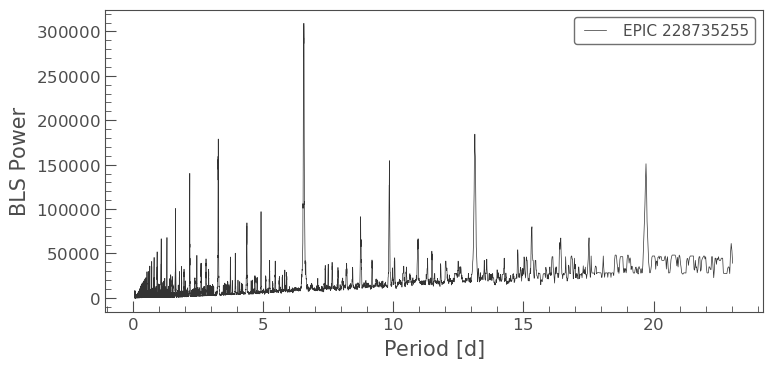

In [86]:
pg = corr_lc_f.to_periodogram("bls", frequency_factor=5, duration=0.05)
pg.plot();

(<Time object: scale='tdb' format='jd' value=2457583.8373304126>,
 <Quantity 6.57284948 d>)

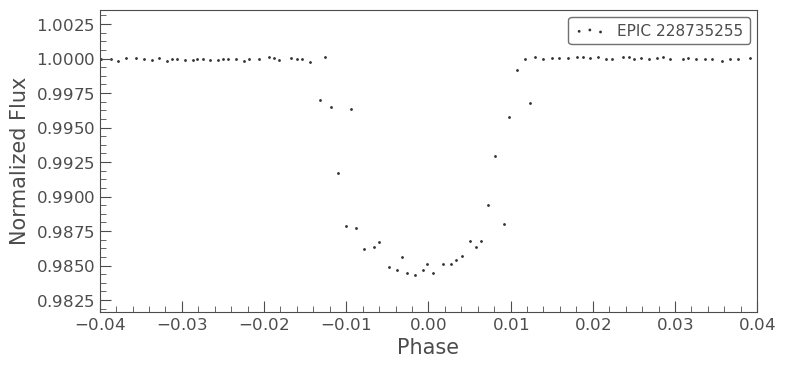

In [94]:
lcf = corr_lc_f.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(2)
lcf.scatter()
plt.xlim([-0.04, 0.04]);
pg.transit_time_at_max_power+corr_lc_f.astropy_time[0], pg.period_at_max_power,

From this, we get that the period is 6.5690 days.

I will now save this lightcurve to use it directly afterwards:

In [4]:
hdu = lcf.to_fits(path='EPIC_228735255_transit.fits', overwrite=True)

### Analysing the object:

Now, knowing that the concerned star's radius is $1.094 R_\odot = 9.8258 R_{Jup}$, and using the formula:
$$ \dfrac{\Delta F}{F} = \dfrac{R_p^2}{R_\odot^2} $$
we can compute the object's radius:

In [5]:
import math

R_star_sr = 1.094 # in sun's radius
R_star = R_star_sr * 695510000 # in meter

T_transit_values = lcf.time[lcf.flux < 0.9999]
T_transit = T_transit_values[-1] - T_transit_values[0]

R_planet = math.sqrt(1-min(lcf.flux))*R_star
R_planet = R_planet / R_star # in jupiter's radius

R_planet, T_transit_values[-1], T_transit_values[0]

(0.12348344478680859, 0.13098215253291984, -0.3849614159591056)

We got $R_p = 1.2432 R_{Jup}$.

Considering $M_p << M_{*}$ and $R_p << R_{*}$, we get the following relations:
$$ a \approx \left( GM_*\left( \dfrac{P^2}{2\pi} \right) \right)^{1/2} $$

$$ i \approx cos^{-1}\left( \left( \left( \dfrac{R_*}{a} \right)^2 - \left( \dfrac{T_{dur} \pi}{P} \right)^2 \right)^{1/2}  \right) $$

$$ b = acos(i) $$

With $T_{dur}$ being the time of the transit.

In [6]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 1.010*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (T_transit*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b 

(13.54612093323871, 85.76646714636466, 0.9999999992525733)

|      EPIC          |       228735255         |
|:------------------:|:-----------------------:|
|   Planet's period  |       6.5690 days       |
|   Planet's radius  | 1.2377 Jupiter's radius |
| Transit's duration |       0.0232 days       |
|     Inclination    |      88.866°            |
|   Semi-major axis  |        0.2024 AU        |
|   Temperature      |       5654 K            |

Now, we want the limb darkening of our star. For that, we'll use [D. K. Sing's paper](https://arxiv.org/pdf/0912.2274.pdf) on LDCs and the properties of our star: type G5 with a temperature of $5695K$.

The quadratic law:
$$\dfrac{I(\mu)}{I(1)} = 1-u_1(1-\mu) - u_2(1-\mu)^2 $$
With Kepler Stellar Limb-Darkening Coefficients (avereging between 5500K and 5750K), $u_1=0.4218$ and $u_2=0.2442$.

In [7]:
u1 = 0.4218
u2 = 0.2442
µ = math.cos(math.asin(b))

I_b = 1 - u1*(1-µ) - u2*((1-µ)**2)

I_b, µ

(0.33403519100104173, 3.866333342659047e-05)

In [8]:
R_planet = R_planet * 69911000
R_planet = math.sqrt((1-min(lcf.flux))/I_b)*R_star
R_planet = R_planet / 69911000

R_planet*11.2

26.043888902636482

## With batman package:

Importing the batman package:

In [9]:
import batman #package by Laura Kreidberg:  http://astro.uchicago.edu/~kreidberg/batman/

Setting the parameters with what we got from the previous method:

In [10]:
params = batman.TransitParams()
params.t0 = 0                      #time of inferior conjunction
params.per = abs(lcf[-1].phase - lcf[0].phase)                      #orbital period
params.rp = 0.126                      #planet radius (in units of stellar radii)
params.a = 13.54                     #semi-major axis (in units of stellar radii)
params.inc = 88                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.4218, 0.2442]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

Creating the fit's space:

In [11]:
t = np.linspace(lcf[0].phase, lcf[-1].phase, len(lcf.flux))    #where the transit is

Creating the model with batman:

In [12]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

Plotting the curve with our first values to get an idea on the errors:

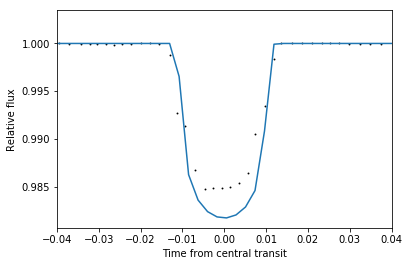

In [13]:
plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlim([-0.04, 0.04]);
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

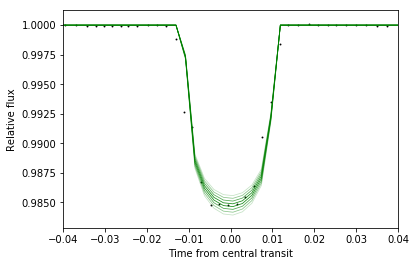

Planet's radius: 0.11544444444444445


In [14]:
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(0.111, 0.119, 10)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(r - ((0.119+0.111)/2))/((0.119-0.111)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcf.flux[count]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.show()
pos_min = 0
for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1] and possible_radii[i][1]<possible_radii[pos_min][1]):
        pos_min = i
        
print("Planet's radius: " + str(possible_radii[pos_min][0]))
params.rp = possible_radii[pos_min][0]

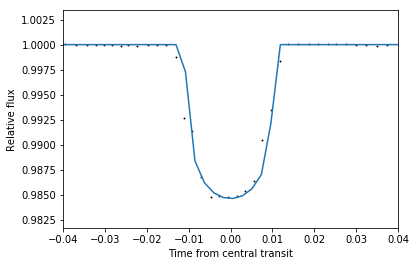

In [15]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04])
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

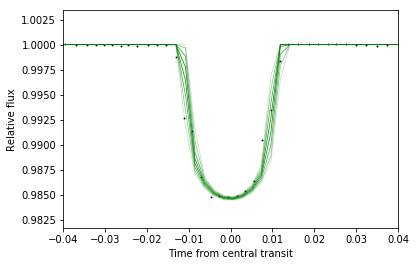

Planet's semi-major axis: 12.333333333333334


In [16]:
plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(12, 15, 10)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(a - ((15+12)/2))/((15-12)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcf.flux[count]-f)
            count += 1
        possible_axis.append([a,diff])

plt.xlim([-0.04, 0.04]);
plt.show()
pos_min = 0
for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1] and possible_axis[i][1]<possible_axis[pos_min][1]):
        pos_min = i

print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]))
params.a = possible_axis[pos_min][0]

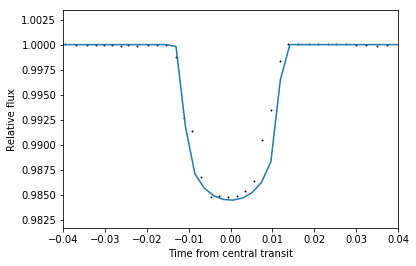

In [17]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

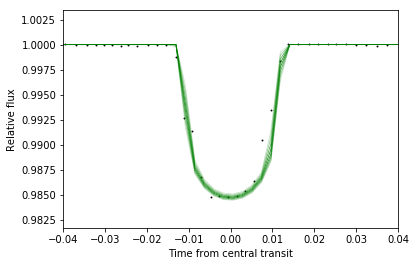

Planet's inclination: 87.83333333333333


In [18]:
plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(87.3, 88.1, 10)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(i - ((88.1+87.3)/2))/((88.1-87.3)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcf.flux[count]-f)
            count += 1
        possible_inc.append([i,diff])

plt.xlim([-0.04, 0.04]);
plt.show()
pos_min = 0
for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1] and possible_inc[i][1]<possible_inc[pos_min][1]):
        pos_min = i

print("Planet's inclination: " + str(possible_inc[pos_min][0]))
params.i = possible_inc[pos_min][0]

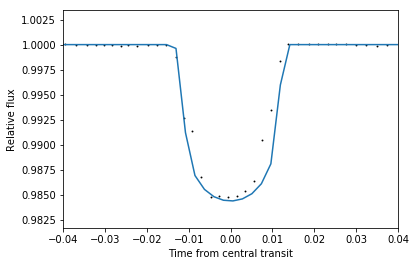

In [19]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

## Using Nikole Lewis' method:

In [20]:
import emcee  #package by Dan Foreman-Mackey:  http://dan.iel.fm/emcee/current/
import corner #package by Dan Foreman-Mackey:  http://corner.readthedocs.io/en/latest/

In [21]:
#intialize a transit model
def initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark):
	params = batman.TransitParams()
	params.t0 = t0 
	params.per = per
	params.rp = rp
	params.a = a
	params.inc = inc
	params.ecc = ecc
	params.w = w
	params.u = u
	params.limb_dark = limb_dark      

	model = batman.TransitModel(params, t)

	return params, batman.TransitModel(params, t)    #return parameters and model objects 

In [22]:
#prior
def lnprior(theta):
	return 0.  #assumes all priors have uniform probability

In [23]:
#likelihood function 
def lnlike(theta, params, model, t, flux, err):
    params.rp, params.a, params.inc = theta[0], theta[1], theta[2]
    params.t0 = theta[3]
    params.ecc = theta[4]
    params.w = theta[5]
    # params.u = [theta[6],theta[7]]
    lc = model.light_curve(params)
    residuals = flux - lc
    ln_likelihood = -0.5*(np.sum((residuals/err)**2 + np.log(2.0*np.pi*(err)**2)))

    return ln_likelihood

In [24]:
#posterior probability
def lnprob(theta, params, model, t, flux, err):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(theta, params, model, t, flux, err)

In [25]:
t = np.linspace(lcf[0].phase, lcf[-1].phase, len(lcf.flux))    #where the transit is

In [26]:
#Now for some initial parameter guesses
t0 = 0.001  #time of inferior conjunction 
per = abs(lcf[-1].phase - lcf[0].phase)  #orbital period -> contrained from other observations
rp = 0.112  #planet radius (in units of stellar radii)
a = 12.6869   #semi-major axis (in units of stellar radii)
inc = 88.5 #orbital inclination (in degrees)
ecc = 0.  #eccentricity  -> Let's assume for now that the planet is not on an eccentric orbit
w = 90.   #longitude of periastron (in degrees) 
u = [0.341, 0.441]  #limb darkening coefficients
limb_dark = "quadratic" #limb darkening model -> Simple limb darkening model, need to consider other models

In [27]:
#initialize model and parameters
params, m = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

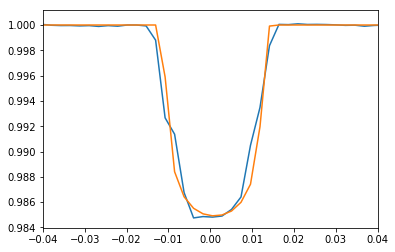

In [28]:
#compare your initial guess with the data and make adjustments
plt.xlim([-0.04, 0.04])
plt.plot(t, lcf.flux) #blue
plt.plot(t, m.light_curve(params)) #green

In [45]:
#now let's get the MCMC initialized
#initial guesses for MCMC fit parameters from your by eye fits
#for simplicity we will only fit for Rp/R*, limb darkening coefficient, and center of transit time
guess_rp, guess_a, guess_i = 0.112, 16, 90
guess_t0 = 0.001
guess_ecc = 0
guess_w = 90
# guess_u1, guess_u2 = 0.4218, 0.2442
theta = [guess_rp, guess_a, guess_i, guess_t0, guess_ecc, guess_w]

In [46]:
#initialize sampler
err = 100.e-6
ndim, nwalkers = len(theta), 100
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (params, m, t, lcf.flux, err))
pos = [theta + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [47]:
#run mcmc
sampler.run_mcmc(pos,500);

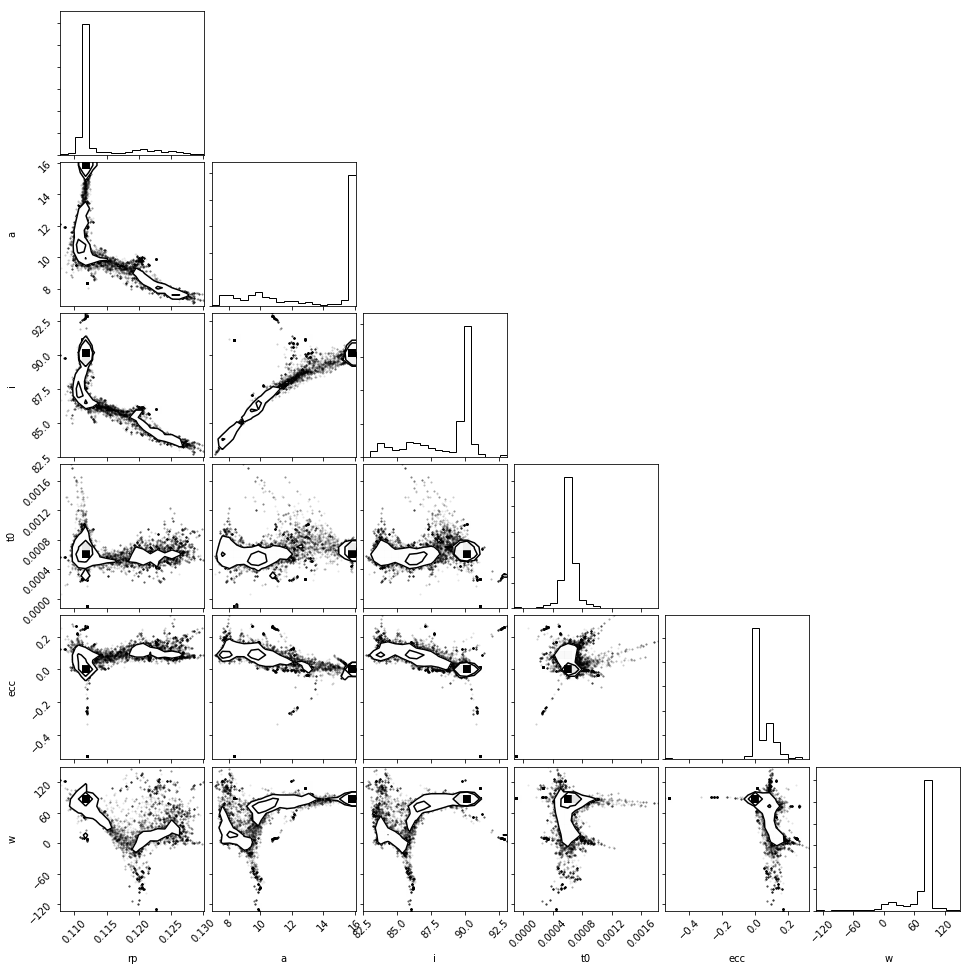

In [48]:
#make a pairs plot from MCMC output
import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim)) #discard first 50 samples as burn-in
fig = corner.corner(samples, labels = ["rp", "a", "i", "t0", "ecc", "w"])
plt.show()

In [49]:
#Now we need to derive the best-fit planet parameters and their 1-sigma error bars
rp_mcmc, a_mcmc, i_mcmc, t0_mcmc, ecc_mcmc, w_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(rp_mcmc)
print(a_mcmc)
print(i_mcmc)
print(t0_mcmc)
print(ecc_mcmc)
print(w_mcmc)
# print(u1_mcmc)
# print(u2_mcmc)

(0.11195651573715142, 0.00603239476784885, 0.00038598245116289176)
(15.737554812089154, 0.22286469102019346, 6.318577551563676)
(89.88599138894698, 0.2976868547465443, 4.08722037112463)
(0.0006337460357670828, 3.526750746320683e-05, 8.347504935457691e-05)
(0.0018614421467997347, 0.095534191796669, 0.005650845700373863)
(89.64750023842181, 0.45757073152923056, 41.21763783868912)


In [50]:
#Now for the final parameter to check
t0 = t0_mcmc[0]  #time of inferior conjunction 
per = abs(lcf[-1].phase - lcf[0].phase)  #orbital period -> contrained from other observations
rp = rp_mcmc[0]  #planet radius (in units of stellar radii)
a = a_mcmc[0]   #semi-major axis (in units of stellar radii)
inc = i_mcmc[0] #orbital inclination (in degrees)
ecc = ecc_mcmc[0]  #eccentricity  -> Let's assume for now that the planet is not on an eccentric orbit
w = w_mcmc[0]   #longitude of periastron (in degrees) 
u = [0.341, 0.441]  #limb darkening coefficients
limb_dark = "quadratic" #limb darkening model -> Simple limb darkening model, need to consider other models

In [51]:
params, m = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

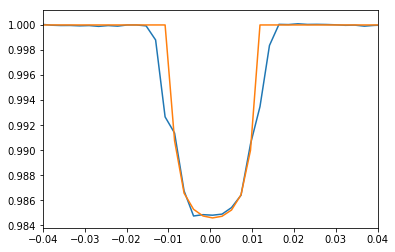

In [52]:
#compare your initial guess with the data and make adjustments
plt.xlim([-0.04, 0.04])
plt.plot(t, lcf.flux) #blue
plt.plot(t, m.light_curve(params)) #green

## Using ExoFAST:

Chi-Squared Parameter Values for EXOFAST Calculation  
Title: EXOFAST-009  
Date : Mon May 13 06:57:56 2019  
Fit Type: CHI2  

| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 6.569156    |
| a      | Semi-Major Axis                   | AU      | 0.069721    |
| Rp     | Planet Radius                     | Rj      | 1.117201    |
| Teq    | Equilibrium Temperature           | K       | 1044.845195 |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.423980    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.132119    |
| i      | Inclination                       | degrees | 89.999285   |
| b      | Impact Parameter                  | none    | 0.000185    |
| delta  | Transit Depth                     | none    | 0.012907    |
| TFWHM  | FWHM Duration                     | days    | 0.141056    |
| tau    | Ingress/Egress Duration           | days    | 0.016049    |
| T14    | Total Duration                    | days    | 0.157105    |

<img src="Screenshot 2019-05-13 at 16.26.05.png" alt=" " title=" " width="500"/>

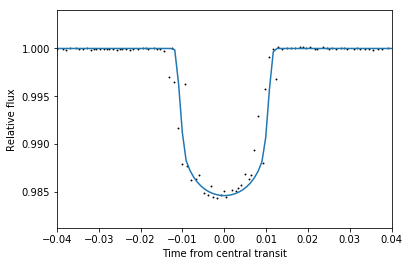

0.01003385238324539

In [95]:
import batman

params = batman.TransitParams()
params.t0 = 0                      #time of inferior conjunction
params.per = abs(lcf[-1].phase - lcf[0].phase)                      #orbital period
params.rp = 0.113608                      #planet radius (in units of stellar radii)
params.a = 14.835795                     #semi-major axis (in units of stellar radii)
params.inc = 89.999285                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.423980, 0.132119]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lcf[0].phase, lcf[-1].phase, len(lcf.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lcf.time, lcf.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlim([-0.04, 0.04]);
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

diff = 0

for i in range(0,len(flux)):
            diff += abs(lcf.flux[i]-flux[i])
        
100*diff/len(flux)